In [14]:
%matplotlib inline

import numpy as np
import rasterio
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
from __future__ import division
import pandas as pd
import seaborn
from rasterstats import zonal_stats


In [27]:
# specify residuals map to read in:
year='2016'
#year = '2016'
#year = '2015'

stable='0515'
#stable='0414'


In [28]:
# read in residuals
residuals_m_fn = '../{year}_analysis/final_products/{year}_{stable}_meanresiduals_forestmask.tif'.format(year=year, stable=stable)
residuals_fn = '../{year}_analysis/final_products/{year}_{stable}_meanresiduals.tif'.format(year=year, stable=stable)

print(residuals_fn)
with rasterio.open(residuals_fn) as image:
    residuals = image.read(1)
print(residuals.shape)
# reassign nodata value (use positive 9999 so we can mask all positive values)
residuals[residuals == -9999] = 9999

print(residuals_m_fn)
with rasterio.open(residuals_m_fn) as image:
    residuals_m = image.read(1)
print(residuals_m.shape)
# reassign nodata value (use positive 9999 so we can mask all positive values)
residuals_m[residuals_m == -9999] = 9999

../2016_analysis/final_products/2016_0515_meanresiduals.tif
(9729, 12851)
../2016_analysis/final_products/2016_0515_meanresiduals_forestmask.tif
(9729, 12851)


In [29]:
NLCD_fn = '/projectnb/landsat/projects/Massachusetts/defoliators/2016_analysis/final_products/NLCD_forest_mask.tif'
with rasterio.open(NLCD_fn) as image:
    NLCD = image.read(1)
print(NLCD.shape)
NLCD[NLCD == -9999] = 0
print(np.unique(NLCD))

(9729, 12851)
[0 1]


In [30]:
# create binary map for different thresholds

thresholds = [-1, -2, -3, -4]
for threshold in thresholds:
    print('Calculating...')
    print(threshold)
    residuals_thresh = (residuals <= threshold).astype(int)
    residuals_thresh_m = (residuals_m <= threshold).astype(int)
    
    in_ds = gdal.Open(residuals_fn, gdal.GA_ReadOnly)
    # write output  to raster
    output_fn = '../elk_plots/threshold/{year}_threshold_{threshold}.tif'.format(year=year, threshold=threshold)
    out_driver = gdal.GetDriverByName("GTiff")
    out_ds = out_driver.Create(output_fn, 
                               residuals.shape[1],  # x size
                               residuals.shape[0],  # y size
                               1,  # number of bands
                               gdal.GDT_Int32)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(residuals_thresh)
    #out_ds.GetRasterBand(1).SetNoDataValue(-9999)
    #out_ds.GetRasterBand(1).SetColorTable(ct)
    #out_ds.GetRasterBand(1).SetDescription('mean standardized residual')
    
    output_m_fn = '../elk_plots/threshold/{year}_threshold_{threshold}_forestmask.tif'.format(year=year, threshold=threshold)
    out_driver = gdal.GetDriverByName("GTiff")
    out_ds = out_driver.Create(output_m_fn, 
                               residuals.shape[1],  # x size
                               residuals.shape[0],  # y size
                               1,  # number of bands
                               gdal.GDT_Int32)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(residuals_thresh_m)
    #out_ds.GetRasterBand(1).SetNoDataValue(-9999)
    #out_ds.GetRasterBand(1).SetColorTable(ct)
    #out_ds.GetRasterBand(1).SetDescription('mean standardized residual')
    out_ds = None
    
    df_all = pd.DataFrame()
    df_for = pd.DataFrame()
    dists = ['1000m', '2000m', '3000m', '4000m', '5000m', '10000m']
    for dist in dists:
        vector = '/projectnb/landsat/projects/Massachusetts/defoliators/elk_plots/GIS_data/moth_plots_{dist}.shp'.format(dist=dist)
        
        stats = zonal_stats(vector, output_fn, nodata=-9999, stats=['count','sum'], geojson_out=True)
        zonal = pd.DataFrame(stats)
        
        stats_m = zonal_stats(vector, output_m_fn, nodata=-9999, stats=['count','sum'], geojson_out=True)
        zonal_m = pd.DataFrame(stats_m)
        
        key_list = zonal['properties'].keys()
        
        stats_NLCD = zonal_stats(vector, NLCD_fn, nodata=-9999, stats=['count','sum'], geojson_out=True)
        zonal_NLCD = pd.DataFrame(stats_NLCD)
             
        df_all['ID'] = key_list
        df_for['ID'] = key_list
        
        for i, key in enumerate(key_list):
            df_all.loc[key, 'Town'] = zonal['properties'][key]['Town']
            df_for.loc[key, 'Town'] = zonal['properties'][key]['Town']
        
        for i, key in enumerate(key_list):
            #df.loc[key, 'sum_{dist}'.format(dist=dist)] = zonal['properties'][key]['sum']
            #df.loc[key, 'count_{dist}'.format(dist=dist)] =  zonal['properties'][key]['count']
            df_all.loc[key, 'perc_{dist}'.format(dist=dist)] =  (zonal['properties'][key]['sum'] / zonal['properties'][key]['count'])*100
            #df.loc[key, 'forest_{dist}'.format(dist=dist)] =  zonal_NLCD['properties'][key]['sum']
            df_for.loc[key, 'percfor_{dist}'.format(dist=dist)] = (zonal_m['properties'][key]['sum'] / zonal_NLCD['properties'][key]['sum'])*100
        
        df_all.to_csv('../elk_plots/threshold/stats_all_{threshold}.csv'.format(threshold=threshold))
        df_for.to_csv('../elk_plots/threshold/stats_forest_{threshold}.csv'.format(threshold=threshold))

Calculating...
-1
Calculating...
-2
Calculating...
-3
Calculating...
-4


In [31]:
dataset = 'forest'

In [32]:
stats_1 = pd.read_csv('../elk_plots/threshold/stats_{dataset}_-1.csv'.format(dataset=dataset))
stats_2 = pd.read_csv('../elk_plots/threshold/stats_{dataset}_-2.csv'.format(dataset=dataset))
stats_3 = pd.read_csv('../elk_plots/threshold/stats_{dataset}_-3.csv'.format(dataset=dataset))
stats_4 = pd.read_csv('../elk_plots/threshold/stats_{dataset}_-4.csv'.format(dataset=dataset))

In [33]:
if dataset == 'forest':
    fields = ['percfor_1000m', 'percfor_2000m','percfor_3000m',
              'percfor_4000m', 'percfor_5000m', 'percfor_10000m']
else:
    fields = ['perc_1000m', 'perc_2000m','perc_3000m',
              'perc_4000m', 'perc_5000m', 'perc_10000m']

stats_1_arr = np.asarray(stats_1[fields])
stats_2_arr = np.asarray(stats_2[fields])
stats_3_arr = np.asarray(stats_3[fields])
stats_4_arr = np.asarray(stats_4[fields])


In [34]:
stats_1['Town'][9] = 'Charlestown B'

/projectnb/landsat/users/valpasq/conda/envs/moths/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


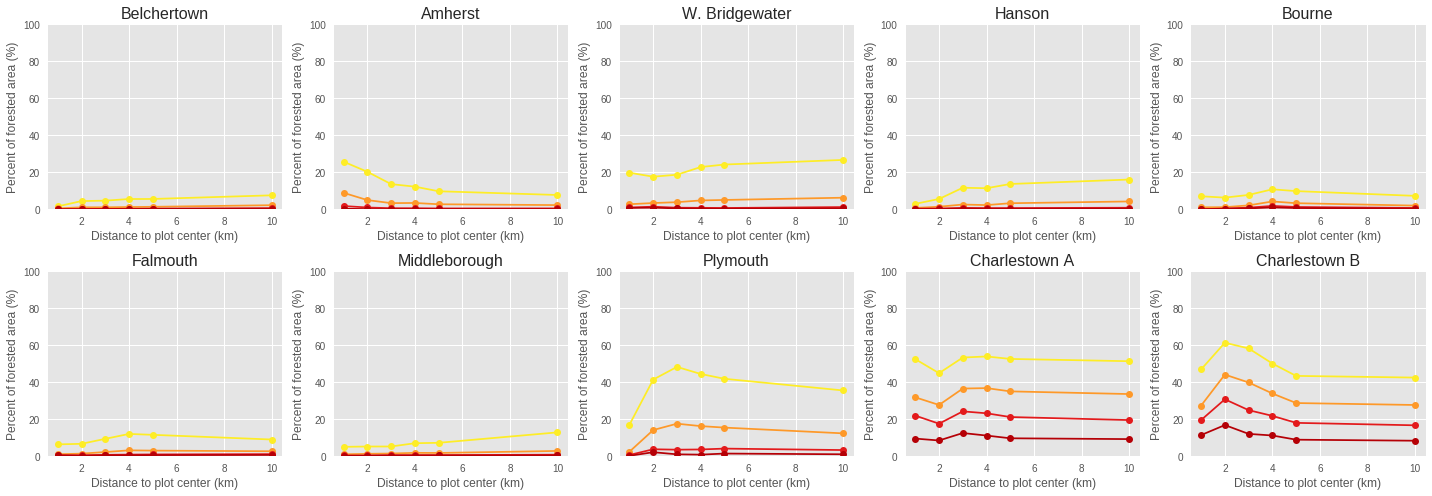

In [35]:
dist = [1, 2, 3, 4, 5, 10]
sites = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig = plt.figure(figsize=(20,7))
plt.style.use('ggplot') 
for site in sites:
    town = stats_1['Town'][site]
    ax = fig.add_subplot(2,5,(site+1))
    plt.plot(dist, stats_1_arr[site], marker='o', color="#feed26")
    plt.plot(dist, stats_2_arr[site], marker='o', color="#fe9929")
    plt.plot(dist, stats_3_arr[site], marker='o', color="#e31a1c")
    plt.plot(dist, stats_4_arr[site], marker='o', color="#b50006")
    plt.title('{town}'.format(town=town), fontsize=16)
    if dataset == 'forest':
        plt.ylabel('Percent of forested area (%)')
    else: 
        plt.ylabel('Percent of total area (%)')
    plt.ylim((0,100))
    plt.xlabel('Distance to plot center (km)')

plt.tight_layout()
if dataset == 'forest':
    plt.savefig('../elk_plots/figures/plot_semivar_forest_{year}.png'.format(year=year), dpi=400)
else: 
    plt.savefig('../elk_plots/figures/plot_semivar_all_{year}.png'.format(year=year), dpi=400)     
plt.show()

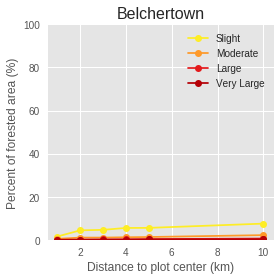

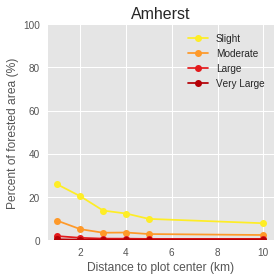

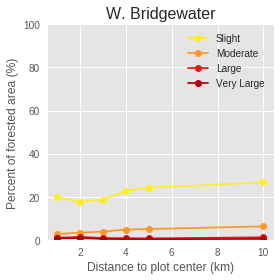

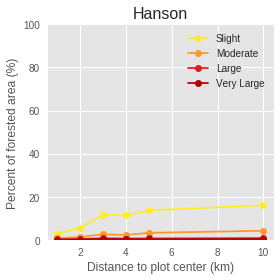

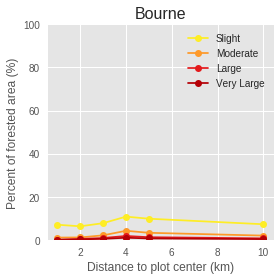

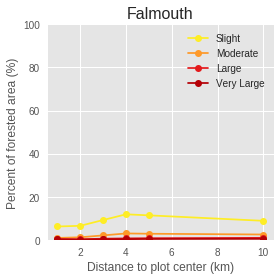

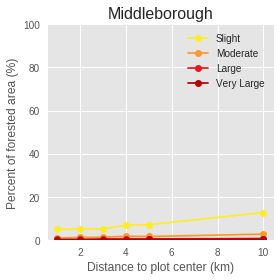

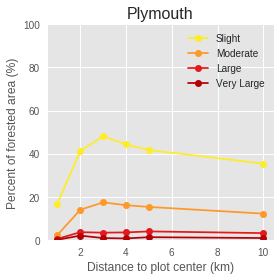

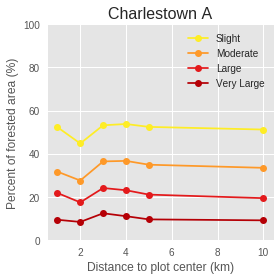

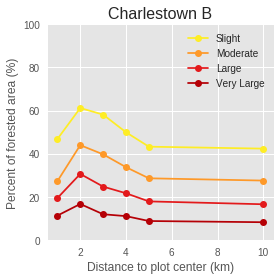

In [36]:

plt.style.use('ggplot') 
for site in sites:
    town = stats_1['Town'][site]
    fig = plt.figure(figsize=(4,4))
    plt.plot(dist, stats_1_arr[site], marker='o', color="#feed26", label='Slight')
    plt.plot(dist, stats_2_arr[site], marker='o', color="#fe9929", label='Moderate')
    plt.plot(dist, stats_3_arr[site], marker='o', color="#e31a1c", label='Large')
    plt.plot(dist, stats_4_arr[site], marker='o', color="#b50006", label='Very Large')
    plt.title('{town}'.format(town=town), fontsize=16)
    if dataset == 'forest':
        plt.ylabel('Percent of forested area (%)')
    else: 
        plt.ylabel('Percent of total area (%)')
    plt.ylim((0,100))
    plt.xlabel('Distance to plot center (km)')
    
    plt.legend()

    plt.tight_layout()
    
    if dataset == 'forest':
        plt.savefig('../elk_plots/figures/plot_semivar_forest_{year}_{town}.png'.format(year=year,town=town), dpi=400)
    else: 
        plt.savefig('../elk_plots/figures/plot_semivar_all_{year}_{town}.png'.format(year=year,town=town), dpi=400)  
    plt.show()
